In [2]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from imp import reload
from scipy.stats import entropy
from scipy.special import factorial
%matplotlib inline

from info_measures import dataset_generators as dg
import info_measures.numpy.kraskov_stoegbauer_grassberger as ksg

ImportError: No module named 'info_measures'

In [11]:
# Load and remove zeros
mnist = input_data.read_data_sets('.', one_hot=False, validation_size=0, reshape=False)
X = mnist.train.images
X = X[:,2:-2,2:-2]

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [15]:
from skimage.transform import rescale

In [12]:
labels = mnist.train.labels

(24, 24, 1)
(24, 24, 1)
(24, 24, 1)
(24, 24, 1)
(24, 24, 1)
(24, 24, 1)
(24, 24, 1)
(24, 24, 1)
(24, 24, 1)
(24, 24, 1)


/home/jesse/anaconda3/envs/dl4em/lib/python3.5/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/jesse/anaconda3/envs/dl4em/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


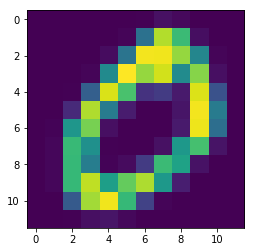

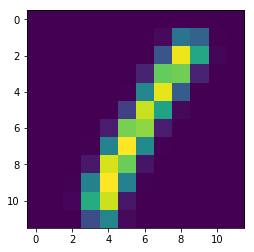

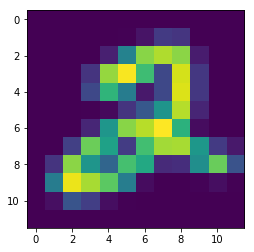

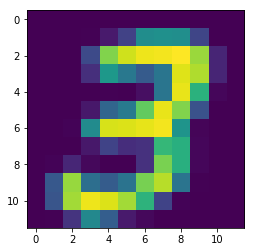

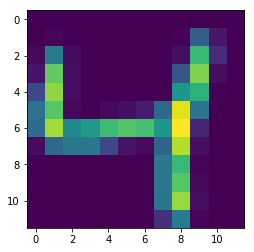

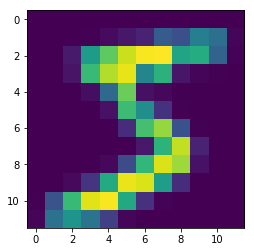

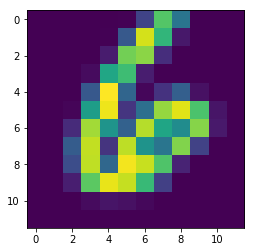

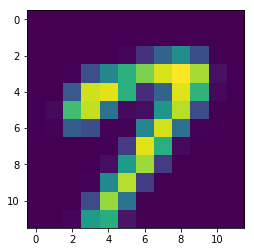

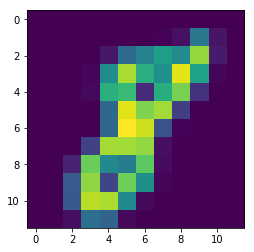

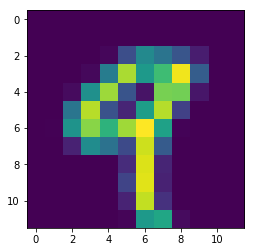

In [22]:
imgs = []
for ii in range(10):
    idxs = labels == ii
    plt.figure()
    print(X[ii].shape)
    img = rescale(np.squeeze(X[idxs][0]), .5, anti_aliasing=True)
    plt.imshow(img)
    imgs.append(img)
plt.show()
imgs = np.stack(imgs)
np.savez('imgs', imgs)

# Image

In [100]:
reload(dg)

dg_mnist = dg.ImageGenerator(X, grow_axis=2)

In [101]:
print(dg_mnist.X.shape)
print(dg_mnist.symmetry_axes)

(60000, 12, 12, 1)
[1, 2]


In [102]:
dim = 4
perp_dim = 7
samples = dg_mnist.sample_data(dim, perp_dim=perp_dim)

here


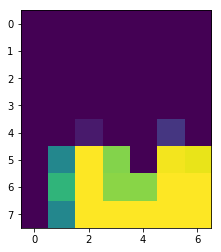

In [114]:
n = 10
plt.imshow(samples[n].reshape(2*dim, perp_dim))

In [115]:
samples.shape

(1800000, 56, 1)

# VectorSpace

In [75]:
reload(dg)
dg_vec = dg.VectorSpaceGenerator(X)

In [76]:
xp = dg_vec.sample_data(grow_dim=1, n_samples=100000)

In [77]:
%timeit dg_vec.sample_data(grow_dim=3, n_samples=1000)

20.5 ms ± 75.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


0.143956322015 0.320517632346
0.142707145499 0.318806047726


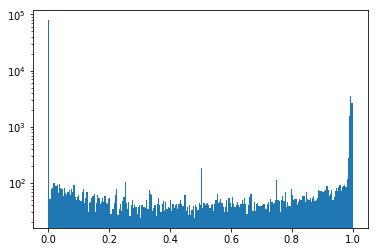

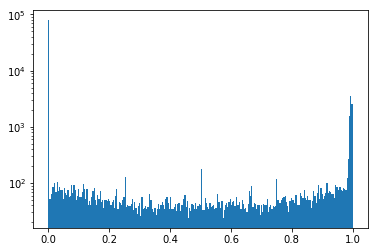

In [78]:
plt.close()
pdfs = []
for ii in range(xp.shape[1]):
    plt.figure()
    pdf, _, _ = plt.hist(xp[:, ii], bins=np.linspace(0, 1, 256))
    print(xp[:, ii].mean(), xp[:, ii].std())
    pdfs.append(pdf)
    plt.yscale('log')

In [158]:
im = np.zeros((14, 14))
im2 = np.zeros((14, 14))
for ii in range(14):
    for jj in range(ii):
        im[ii, jj] = entropy(pdfs[ii], pdfs[jj])
        im2[ii,jj] = np.dot(xp[:,ii,0]-xp[:,ii,0].mean(), xp[:,jj]-xp[:,jj].mean())

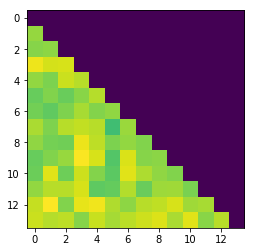

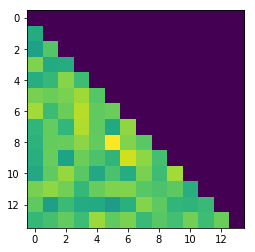

In [160]:
plt.imshow(im)
plt.figure()
plt.imshow(im2)

In [99]:
ksg_e = ksg.MutualInformation(xp[:,:3,0], xp[:,3:,0], add_noise=True)

In [100]:
ksg_e.mutual_information()

0.032866438432568756

In [97]:
ksg_e2 = ksg.MutualInformation(xp[:,0][np.random.permutation(60000)], xp[:,1], add_noise=True)

In [98]:
ksg_e2.mutual_information()

0.0032976463352465402

# MultiChannelTimeseries

In [52]:
reload(dg)

dg_time = dg.MultiChannelTimeseriesGenerator(X)

In [55]:
n_t = 1
xp = dg_time.sample_data(n_t, 2, n_samples=700000)

iters 1
0 1620000 700000


In [56]:
xp.shape

(700000, 4, 1)

In [45]:
x0 = xp[::1000, :n_t]
x0 = x0.reshape(x0.shape[0], -1)
x1 = xp[::1000, n_t:]
x1 = x1.reshape(x0.shape[0], -1)
ksg_e = ksg.MutualInformation(x0, x1, add_noise=True)

/home/jesse/Development/info_measures/info_measures/numpy/kraskov_stoegbauer_grassberger.py:107: RuntimeWarning: invalid value encountered in true_divide
  X = X / X.std(axis=0, keepdims=True)


In [46]:
ksg_e.mutual_information()

0.14803318941509325

# Number of multichannel timeseries samples

In [2]:
# batch size
n_X = 1
# time steps
n_t = 500000
# channels
n_c = 128
# features
n_f = 1

# channels per sample
c = 1
# time per sample (doubled for PI)
t = 1

n_s = n_X * factorial(n_c, exact=True) // factorial(n_c-c, exact=True) * ((n_t) + 1 - 2*t)
print('{} samples'.format(n_s))
print('{} MB'.format(np.around(64 * n_f * n_s / 8 / 1024**2, 2)))

63999872 samples
488.28 MB


# Number of linear image samples

In [40]:
# batch size
n_X = 60000
# width (PI direction)
n_w = 28
# height (channels direction)
n_h = 28
# features
n_f = 1

# height (channels) per sample
H = 1
# width(time) per sample (doubled for PI)
W = 1

n_s = n_X * ((n_w) + 1 - 2*W) * ((n_h) + 1 - H)
print('{} samples'.format(n_s))
print('{} MB'.format(np.around(64 * n_f * n_s / 8 / 1024**2, 2)))

45360000 samples
346.07 MB


# Number of vectorspace samples

In [45]:
# batch size
n_X = 60000
# channels (PI direction)
n_c = 28 * 28
# features
n_f = 1

# channels (time) per sample (doubled for PI)
c = 1

n_s = n_X * factorial(n_c, exact=True) // factorial(n_c-2*c, exact=True)
print('{} samples'.format(n_s))
print('{} GB'.format(np.around(64 * n_f * n_s / 8 / 1024**3, 2)))

36832320000 samples
274.42 GB
